In [1]:
%matplotlib inline
import os
import time
import pygpc
import warnings
import numpy as np
import matplotlib.cbook
import matplotlib.pyplot as plt
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

heading
# Heading
## Heading
### Heading
link: [YAML](https://yaml.org/spec/1.2/spec.html)

yaml code:
```yaml
PRO:
  base: OperatorTemplate
  equations: "m_out = m_max / (1. + exp(r*(V_thr - PSP)))"
  variables:
    m_out:
      default: output
    PSP:
      default: input
    m_max:
      default: 5.
    r:
      default: 560.
    V_thr:
      default: 6e-3
```

python code:
```python
def test(a, b)
    return a+b
```

new line equation:
$$m_{out} = \frac{m_{max}}{1. + \exp{(r \cdot (V_{thr} - V))}}.$$

inline equation: $x+y$

*italic* font
**bold** font

`grey shaded`

This command <br />
makes a new line

# Tutorial: Uncertainty and Sensitivity Analysis using Generalized Polynomial Chaos and pygpc

This tutorial shows you how to perform an uncertainty and sensitivity analysis using pygpc. The following topics will be discussed:
1. Introduction to uncertainty and sensitivity analysis
2. Introduction to generalized polynomial chaos
2. State-of-the-art features of the toolbox
3. Setting up a model to analyze using pypgc
4. Postprocessing and interpretation of the obtained results

## Part 1: Introduction to uncertainty and sensitivity analysis and generalized polynomial chaos

Typically, we have some model, which depends on parameters and we are interested in several quantities of interest (QOI), we can compute, when we run the model with the desired set of parameters. However, 

FIGURE: System to analyze with In- and Output

### Uncertainty analysis using Monte Carlo methods
In order to determine the statistical information of the output quantities of a system, such as the mean or the variance, one of the most common methods is Monte Carlo sampling (MC). The MC method is based on repetitive calculations of the forward model, while defining the random inputs according to their probability distributions. This results in an ensemble of solutions from which statistical properties can be derived. However, a large number of simulations is needed due to the slow convergence rate of the MC method. The mean for example converges with $1/\sqrt{N}$, where $N$ is the number of deterministic forward calculations. This limits the applicability to problems with low computational cost.

### Example:
Three-dimensional test function of Ishigami.
$$
y = \sin(x_1) + a \sin(x_2)^2 + b x_3^4 \sin(x_1)
$$
The Ishigami function of Ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on $x_3$, as described by Sobol' & Levitan (1999). The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1.

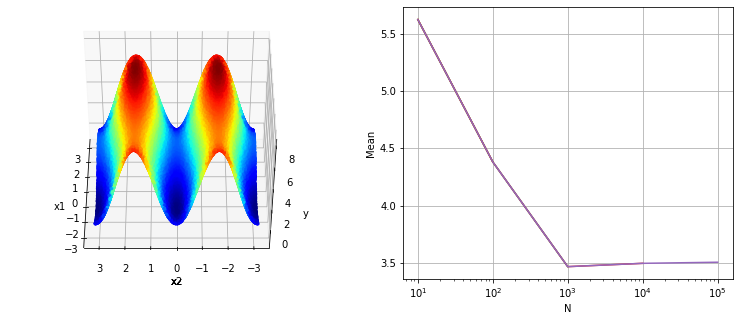

In [3]:
# Parameters
p = dict()
p["x1"] = (np.random.rand(int(1e5))-0.5)*2*np.pi
p["x2"] = (np.random.rand(int(1e5))-0.5)*2*np.pi
p["x3"] = np.zeros(p["x1"].shape)
p["a"] = 7
p["b"] = 0.1

# Model
model = pygpc.testfunctions.Ishigami(p)

# Run simulations
y = model.simulate()

# Plot results
fig = plt.figure(figsize=[13, 5])

N = np.logspace(1, 5, 5).astype(int)
mean = []

for i in range(len(N)):
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(p["x1"][:N[i]], 
                p["x2"][:N[i]], 
                y[:N[i]], 
                s=4, c=y[0:N[i]].flatten(), cmap="jet")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    ax1.set_zlabel("y")
    ax1.view_init(elev=45, azim=180)
        
    ax2 = fig.add_subplot(122)
    mean.append(np.mean(y[:N[i]]))
    ax2.plot(N[:i+1], mean)
    ax2.set_xscale("log")
    ax2.grid(True)
    ax2.set_xlabel("N")
    ax2.set_ylabel("Mean")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    time.sleep(3)

### How can we do better?
### Generalized Polynomial Chaos
The primary focus of this tutorial rests on spectral methods, which are based on the determination of a functional dependence between the probabilistic in- and output of a system by means of a series of suitable selected functionals. The practical realization of spectral methods can be further subdivided into *intrusive* and **non-intrusive** approaches. Intrusive approaches are based on Galerkin methods, where the governing equations have to be modified to incorporate the probabilistic character of the model parameters. This includes the determination of the stochastic weak form of the problem according to the given uncertainties [LeMaitre.2010]. On the contrary,  non-intrusive approaches are based on a reduced sampling of the probability space without any modification of the deterministic solvers. Those methods are more flexible and thus more suitable for universal application. Typical applications can be found in the fields of computational fluid dynamics [Knio.2006, Xiu.2003, Hosder.2006], heat transfer [Wan.2004, Xiu.2003b], multibody dynamics [Sandu.2006, Sandu.2006b], robust design optimization [Zein.2013] or in biomedical engineering [Saturnino.2019, Weise.2015, Codecasa.2016]. During the last years, spectral approaches are becoming increasingly popular. However, those are not a reference tool yet and still unknown for many people. For that reason, particular emphasis is placed to describe the method and to further elucidate the principle by means of examples.


### Random parameters
The $d$ parameters of interest, which are assumed to underlie a distinct level of uncertainty, are modeled as a $d$-variate random vector denoted by $\mathbf{\xi} = (\xi_1, \, \xi_2, \, ... \xi_d)$. It is defined in the probability space $(\Theta, \Sigma, P)$. The event or random space $\Theta$ contains all possible events. $\Sigma$ is a $\sigma$-Algebra over $\Theta$, containing sets of events, and $P$ is a function assigning the probabilities of occurrence to the events. The number of random variables $d$ determines the *dimension* of the uncertainty problem. It is assumed that the parameters are statistically mutually independent from each other. In order to perform a gPC expansion, the random variables must have a finite variance, which defines the problem in the $L_2$-Hilbert space.<br />
The probability density function (pdf) $p_i(\xi_i)$, with $i=1,...,d$, has to be defined for each random variable $\xi_i$. <br />
Currently, **pygpc** supports:

#### $\beta$ distributed random variables:


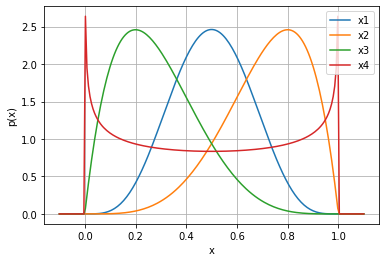

In [6]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[5, 5], pdf_limits=[0, 1])
parameters["x2"] = pygpc.Beta(pdf_shape=[5, 2], pdf_limits=[0, 1])
parameters["x3"] = pygpc.Beta(pdf_shape=[2, 5], pdf_limits=[0, 1])
parameters["x4"] = pygpc.Beta(pdf_shape=[0.75, 0.75], pdf_limits=[0, 1])
ax = parameters["x1"].plot_pdf()
ax = parameters["x2"].plot_pdf()
ax = parameters["x3"].plot_pdf()
ax = parameters["x4"].plot_pdf()
ax.legend(["x1", "x2", "x3", "x4"])

#### *Uniform* distributed random variables:

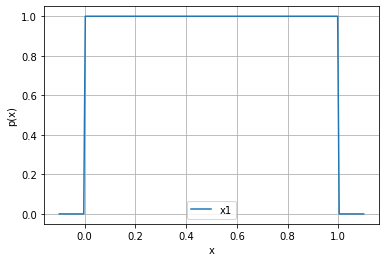

In [7]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[0, 1])
ax = parameters["x1"].plot_pdf()
ax.legend(["x1"])

#### *Normal* distributed random variables:

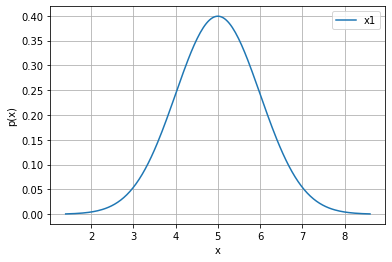

In [8]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Norm(pdf_shape=[5, 1])
ax = parameters["x1"].plot_pdf()
ax.legend(["x1"])

### Quantities of Interest (QOI)
The quantity of interest (QOI), which will be analyzed in terms of the random variables ${\xi}$, is $y(\mathbf{r})$. It may depend on some external parameters $\mathbf{r}=(r_{0},\,...,\,r_{R-1})$ like spatial coordinates, where $R=3$, or any other *constant* parameter. Those are treated as deterministic and are not considered in the uncertainty analysis. A separate gPC expansion has to be performed for every considered parameter set $\mathbf{r}$. The discrete number of QOIs is denoted as $N_y$.

### The gPC expansion
The basic concept of the gPC is to find a functional dependence between the random variables ${\xi}$ and the solutions $y(\mathbf{r},{\xi})$ by means of an orthogonal polynomial basis $\Psi({\xi})$. In its general form, it is given by: 

$$
y(\mathbf{r},{\xi}) = \sum_{\mathbf{\alpha}\in\mathcal{A}(\mathbf{p})} u_{\mathbf{\alpha}}(\mathbf{r}) \Psi_{\mathbf{\alpha}}({\xi}).
$$

The terms are indexed by the multi-index  $\mathbf{\alpha}=(\alpha_0,...,\alpha_{d-1})$, which is a $d$-tuple of non-negative integers $\mathbf{\alpha}\in\mathbb{N}_0^d$. The sum is carried out over the multi-indices, contained in the set $\mathcal{A}(\mathbf{p})$. The composition of the set depends on the type of expansion and is parameterized by a parameter vector $\mathbf{p}$, which will be explained in a later part of this section.

The function $\Psi_{\mathbf{\alpha}}({\xi})$ are the joint polynomial basis functions of the gPC. They are composed of polynomials $\psi_{\alpha_i}(\xi_i)$.

$$
\Psi_{\mathbf{\alpha}}({\xi}) = \prod_{i=1}^{d} \psi_{\alpha_i}(\xi_i)
$$

The polynomials $\psi_{\alpha_i}(\xi_i)$ are defined for each random variable separately according to the corresponding pdf $p_i(\xi_i)$. They have to be chosen to ensure orthogonality. The set of polynomials for an optimal basis of continuous probability distributions is derived from the Askey scheme [Askey.1985]. The index of the polynomials denotes its order (or degree). In this way, the multi-index $\mathbf{\alpha}$ corresponds to the order of the individual basis functions forming the joint basis function.

| Type      | Distribution | Orthogonal polynomials | Range               |
|-----------|--------------|------------------------|---------------------|
|continuous | uniform      | Legendre               | $(a,b)$             |
|continuous | beta         | Jacobi                 | $(a,b)$             |
|continuous | gaussian     | Hermite                | $(-\infty,+\infty)$ |
| discrete  | poisson      | Charlier               | $(0,1,...)$         |

#### Probabilists Hermite polynomials $He_n(x)$:
Orthogonal with respect to weight function $\textrm{e}^{-\frac{x^2}{2}}$
$$\int_{-\infty}^{\infty} He_nHe_m \textrm{e}^{-\frac{x^2}{2}}\,\textrm{d}x = \sqrt{2\pi}n!\delta_{mn}$$
$$He_0(x) = 1$$
$$He_1(x) = x$$
$$He_2(x) = x^2-1$$
$$He_3(x) = x^3-3x$$
$$...$$

#### Jacobi polynomials for $\alpha=q-1$ and $\beta=p-1$
Orthogonal with respect to weight function $(x+1)^{\beta}(1-x)^{\alpha}$ on interval $[-1,1]$ (in terms of shape parameters of Beta distribution: $\beta=p-1$, $\alpha=q-1$). 

$$\int_{-1}^{1} P_n^{\alpha,\beta}(x) P_m^{\alpha,\beta}(x) (x+1)^{\beta}(1-x)^{\alpha}\,\textrm{d}x = \frac{2^{\alpha+\beta+1}}{2n+\alpha+\beta+1}\frac{\Gamma(n+\alpha+1)\Gamma(n+\beta+1)}{\Gamma(n+\alpha+\beta+1)n!}\delta_{mn}$$

where $\Gamma(z)$ is the Gamma function

$$\Gamma(z) = \int_0^\infty t^{z-1}e^{-t} \mathrm{d}t $$



$$P_0^{(0,0)}(x) = 1$$
$$P_1^{(0,0)}(x) = x$$
$$P_2^{(0,0)}(x) = \frac{1}{2}(3x^2-1)$$
$$P_3^{(0,0)}(x) = \frac{1}{2}(5x^3-3x)$$
$$...$$

### Orthogonality
Orthogonality of the polynomial basis for the uni-variate case is given by:

$$
\int_{\Theta}\psi_m(\xi_i)\psi_n(\xi_i)p_i(\xi_i)\,\textrm{d}\xi_i = \delta_{mn}\left\langle \psi_m^2 \right\rangle
$$

The orthogonality also holds for the joint polynomial basis functions $\Psi_{\mathbf{\alpha}}({\xi})$ even if different families of orthogonal polynomials are considered in the gPC, which means that an individual pdf can be assigned to each random variable:

$$\int_{\Theta} \Psi_{\mathbf{m}} \Psi_{\mathbf{n}} p({\xi})\,\textrm{d}{\xi} = \prod_{i=1}^{d}\int_{\Theta}\psi_{m_i}(\xi_i)\psi_{n_i}(\xi_i)p_i(\xi_i) = \prod_{i=1}^{d} \delta_{m_i n_i}\left\langle\psi_{m_i}^2\right\rangle = \delta_{\mathbf{mn}}\left\langle\Psi_{\mathbf{m}}^2\right\rangle$$

Where $\mathbf{m}=(m_1,\,...,\,m_d)$ and $\mathbf{n}=(n_1,\,...,\,n_d)$ are multi-indices. As soon as one pair of indices is not equal $m_i \neq n_i$, the right hand side vanishes and orthogonality is ensured. The only non-vanishing combination is when $\mathbf{m}=\mathbf{n}$, i.e. ($m_1=n_1,\,...,\, m_d=n_d$).

### Normalization
It is advantageous to normalize the polynomials to form an ortho*normal* basis. The normalization factors of the polynomials are given by the square root of the $\left\langle\psi_{i}^2\right\rangle$ terms. 

For the probabilists Hermite polynomials $He_n(\xi)$, which are orthogonal with respect to the normal distribution, the normalization factor can be derived by:
$$
\int_{-\infty}^{\infty} \big(He_n(\xi)\big)^2  \underbrace{\frac{1}{\sqrt{2\pi}}\textrm{e}^{-\frac{\xi^2}{2}}}_{p(\xi)}\,\textrm{d}\xi = n!.
$$

For the Jacobi polynomials $P_n^{(q-1,p-1)}(\xi)$, which are orthogonal with respect to the beta distribution, the normalization factor in terms of the shape parameters $p$ and $q$ is determined by: 
$$
\int_{-1}^{1} \left(P^{(q-1,p-1)}_n(\xi)\right)^2\underbrace{\frac{1}{B(p,q)}(1-\xi)^{q-1}(1+\xi)^{p-1}}_{p(\xi)}\,\textrm{d}\xi = \frac{1}{B(p,q)}\frac{2^{q+p-1}}{2n+q+p-1}\frac{\Gamma(n+q)\Gamma(n+p)}{\Gamma(n+q+p-1)n!}
$$

Each polynomial is normalized individually by dividing it by the corresponding normalization factor before the joint polynomial basis function $\Psi$ is constructed. This considerably simplifies the post-processing of the gPC expansion, which will be described in a later part of this section. From now on, it is assumed that all polynomials are normalized.

#### Test-problem (Ishigami):

In [9]:
# define model
model = pygpc.testfunctions.Ishigami

# define parameters
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x2"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x3"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])

# define problem
problem = pygpc.Problem(model, parameters)

### Set of basis functions
#### Total-order gPC
In general, the set $\mathcal{A}(\mathbf{p})$ of multi-indices can be freely chosen according to the problem under investigation. In the following figures, the blue boxes correspond to polynomials included in the gPC expansion. The coordinates of the boxes correspond to the multi-indices $\mathbf{\alpha}$, which correspond to the polynomial degrees of the individual basis functions forming the joint basis functions.
For a total-order gPC, the number of basis functions, and hence, coefficients to determine, increases exponentially in this case $N_c=(P+1)^d$.

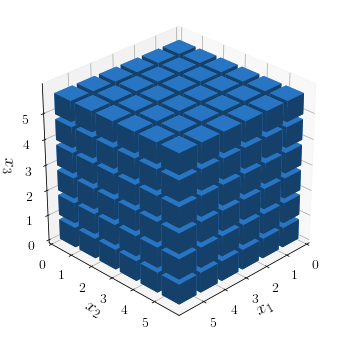

In [10]:
# total-order gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[5, 5, 5],
                      order_max=15,
                      order_max_norm=1,
                      interaction_order=3)

basis.plot_basis(dims=[0, 1, 2])

#### Maximum-order gPC
In practical applications, the more economical maximum total order gPC is preferably used. In this case, the set $\mathcal{A}(p_g)$ includes all polynomials whose total order does not exceed a predefined value $P_g$. 
$$
\mathcal{A}(p_g) = \left\{ \mathbf{\alpha} \, : \, \sum_{i=1}^{d} \alpha_i \leq p_g \right\} = \left\{ \mathbf{\alpha} \, : \lVert \mathbf{\alpha} \rVert_1  \leq P_g \right\}
$$
This results in a reduced set of basis functions and is termed maximum order gPC. The number of multi-indices, and hence, the dimension of the space spanned by the polynomials, is [Eldred.2009]:
$$
N_c = \binom{d+p_g}{d} = \frac{(d+p_g)!}{d!p_g!}.
$$

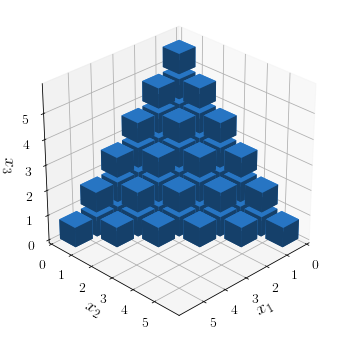

In [11]:
# maximum-order gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[5, 5, 5],
                      order_max=5,
                      order_max_norm=1,
                      interaction_order=3)

basis.plot_basis(dims=[0, 1, 2])

#### Reduced-basis gPC 
The concept of the *maximum-order* gPC is extended by introducing three new parameters:
- the *univariate* expansion order $\mathbf{p}_u = (p_{u,1},...,p_{u,d})$ with $p_{u,i}>p_g \forall i={1,...,d}$
- the *interaction order* $p_i$, limits the number of interacting parameters and it reflects the dimensionality, i.e. the number of random variables (independent variables) appearing in the basis function $\Psi_{\mathbf{\alpha}}({\xi})$: $\lVert\mathbf{\alpha}\rVert_0 \leq p_i$
- the *maximum order norm* $q$ additionally truncates the included basis functions in terms of the maximum order $p_g$ such that $\lVert \mathbf{\alpha} \rVert_{q}=\sqrt[q]{\sum_{i=1}^d \alpha_i^{q}} \leq p_g$

Those parameters define the set $\mathcal{A}(\mathbf{p})$ with $\mathbf{p} = (\mathbf{p}_u,p_i,p_g, q)$

The reduced set $\mathcal{A}(\mathbf{p})$ is then constructed by the following rule:

$$
\mathcal{A}(\mathbf{p}) := \left\{ \mathbf{\alpha} \in \mathbb{N}_0^d\, : (\lVert \mathbf{\alpha} \rVert_q  \leq p_g \wedge \lVert\mathbf{\alpha}\rVert_0 \leq p_i) \vee (\lVert \mathbf{\alpha} \rVert_1  \leq p_{u,i} \wedge \lVert\mathbf{\alpha}\rVert_0 = 1, \forall i \in \{1,...,d\}) \right\} 
$$

It includes all elements from a total order gPC with the restriction of the interaction order $P_i$. Additionally, univariate polynomials of higher orders specified in $\mathbf{P}_u$ may be added to the set of basis functions.

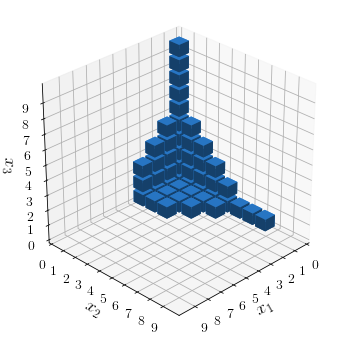

In [17]:
# reduced basis gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[3, 7, 9],
                      order_max=5,
                      order_max_norm=1,
                      interaction_order=2)

basis.plot_basis(dims=[0, 1, 2])

### Nonintrusive methods to determine the gPC coefficients
After constructing the polynomial basis, the corresponding gPC-coefficients $u_{\mathbf{\alpha}}(\mathbf{r})$ have to be determined for each output quantity. In this regard, the output variables are projected from the $d$-dimensional probability space $\Theta$ into the $N_c$-dimensional polynomial space $\mathcal{P}_{N_c}$. In this regard, an analytical approximation of the solutions $y(\mathbf{r},\mathbf{\xi})$ as a function of its random input parameters $\mathbf{\xi}$ is derived. This enables computational efficient investigations on its stochastics. Different methods exist to calculate the gPC-coefficients $u_{\mathbf{\alpha}}(\mathbf{r})$, whereas in the following, two different approaches are described.

#### Spectral projection approach
Due to the orthonormal property of the joint polynomial basis functions $\Psi({\xi})$, the gPC-coefficients $u_{\mathbf{\alpha}}(\mathbf{r})$ can be determined by the following expression [LeMaitre.2010]:

$$
y(\mathbf{r},{\xi}) = \sum_{\mathbf{\alpha}\in\mathcal{A}(\mathbf{P})} u_{\mathbf{\alpha}}(\mathbf{r}) \Psi_{\mathbf{\alpha}}({\xi})
$$

$$
\int_{\Theta}y(\mathbf{r},{\xi}) \Psi_{\mathbf{\alpha}}({\xi}) p({\xi})\,\textrm{d}{\xi} = \int_{\Theta} \Psi_{\mathbf{\alpha}}({\xi}) p({\xi}) \sum_{\mathbf{\alpha}\in\mathcal{A}(\mathbf{P})} u_{\mathbf{\alpha}}(\mathbf{r})\Psi_{\mathbf{\alpha}}({\xi})\,\textrm{d}{\xi}
$$

$$
u_{\mathbf{\alpha}}(\mathbf{r}) = \int_{\Theta}y(\mathbf{r},{\xi}) \Psi_{\mathbf{\alpha}}({\xi}) p({\xi})\,\textrm{d}{\xi}
$$

The gPC-coefficients are determined by finding an approximate solution of the integral above. It can be approximated using a distinct type of Gauss-quadrature, depending on the weighting function $p({\xi})$, which is the joint pdf in the present context. 

$$
u_{\mathbf{\alpha}}(\mathbf{r}) = \int_{\Theta}\underbrace{y(\mathbf{r},{\xi}) \Psi_{\mathbf{\alpha}}({\xi})}_{f(\mathbf{r},{\xi})} \underbrace{p({\xi})}_{w({\xi})}\,\textrm{d}{\xi} \approx \sum_{i=1}^{N_g}y(\mathbf{r},{\xi}_i) \Psi_{\mathbf{\alpha}}({\xi}_i)w_i
$$

The type of Gauss-quadrature determines the location of the quadrature points ${\xi}_i$, where the system under investigation has to be evaluated. Every grid-point has a corresponding weight $w_i$. Both are determined from the  family of orthogonal polynomials associated to the weight function. Those are collected in a set of grid points $\mathcal{G}$ and a set of weights $\mathcal{W}$, which are both of size $N_g$.

The most straightforward approach is a full tensor quadrature. The sampling-points in the $i$-th dimension ${x}^{(0)}_{i}$ are determined by the roots of the corresponding univariate orthogonal polynomial $\psi_{P_q}(\xi_i)$ of some order $P_q$. In practice, it is recommended to adapt the grid to the intended expansion order of the gPC, such that $P_q \geq P_g$. It is reminded that for each random variable, a different polynomial may arise, depending on the respective pdf $p(\xi_i)$, which affects the location of the grid-points. The full grid is then determined by the tensor product of the individual nodes in each dimension:

$$
\mathcal{G} = \mathbf{x}_i^{(0)} \otimes ... \otimes \mathbf{x}_d^{(0)}.
$$

The corresponding weights can be calculated by solving the eigenvalue problem considering the recurrence relationship of the orthogonal polynomials [Golub.1969].
In accordance to the grid coordinates, the set of weights $\mathcal{W}$ is calculated by the tensor product between the weights in each dimension: 

$$
\mathcal{W} = \mathbf{w}_i^{(0)} \otimes ... \otimes \mathbf{w}_d^{(0)}.
$$

In order to accelerate the computation of the gPC-coefficients, it is advisable to rewrite the expression for the gPC coefficients in matrix form. In order to do so, the following matrices are introduced: 
- Coefficient matrix $[\mathbf{U}]$ of size $[N_c \times N_y]$, whose columns are the $N_c$ gPC coefficients for each of the $N_y$ QOIs
- Solution matrix $[\mathbf{Y}]$ of size $[N_g \times N_y]$, whose columns are the model solutions of the $N_y$ QOIs
- gPC matrix $[\mathbf{\Psi}]$ of size $[N_g \times N_c]$, whose columns are the polynomial basis functions evaluated at the grid-points in $\mathcal{G}$
- Weight matrix $[\mathbf{W}]=\textrm{diag}{(\mathbf{w})}$ of size $[N_g \times N_g]$, whose diagonal are all quadrature weights from $\mathcal{G}$ sorted such that they correspond to the $N_g$ grid-points

The coefficient matrix $[\mathbf{U}]$ is then given by:

$$
[\mathbf{U}] = [\mathbf{\Psi}]^{\textrm{T}}[\mathbf{W}][\mathbf{Y}]
$$

It is mentioned that this formulation is independent on the type of quadrature applied to the problem.

#### Regression approach
In the regression approach, the gPC coefficients are estimated using the method of least squares. Assuming that the model is evaluated $N_g>N_c$ times on some grid $\mathcal{G}$, the gPC expansion can be written in matrix form as:

$$
[\mathbf{Y}] = [\mathbf{\Psi}][\mathbf{U}]
$$

The gPC-coefficients for each QOI (columns of $[\mathbf{U}]$) can then be found by using different solvers. <br />

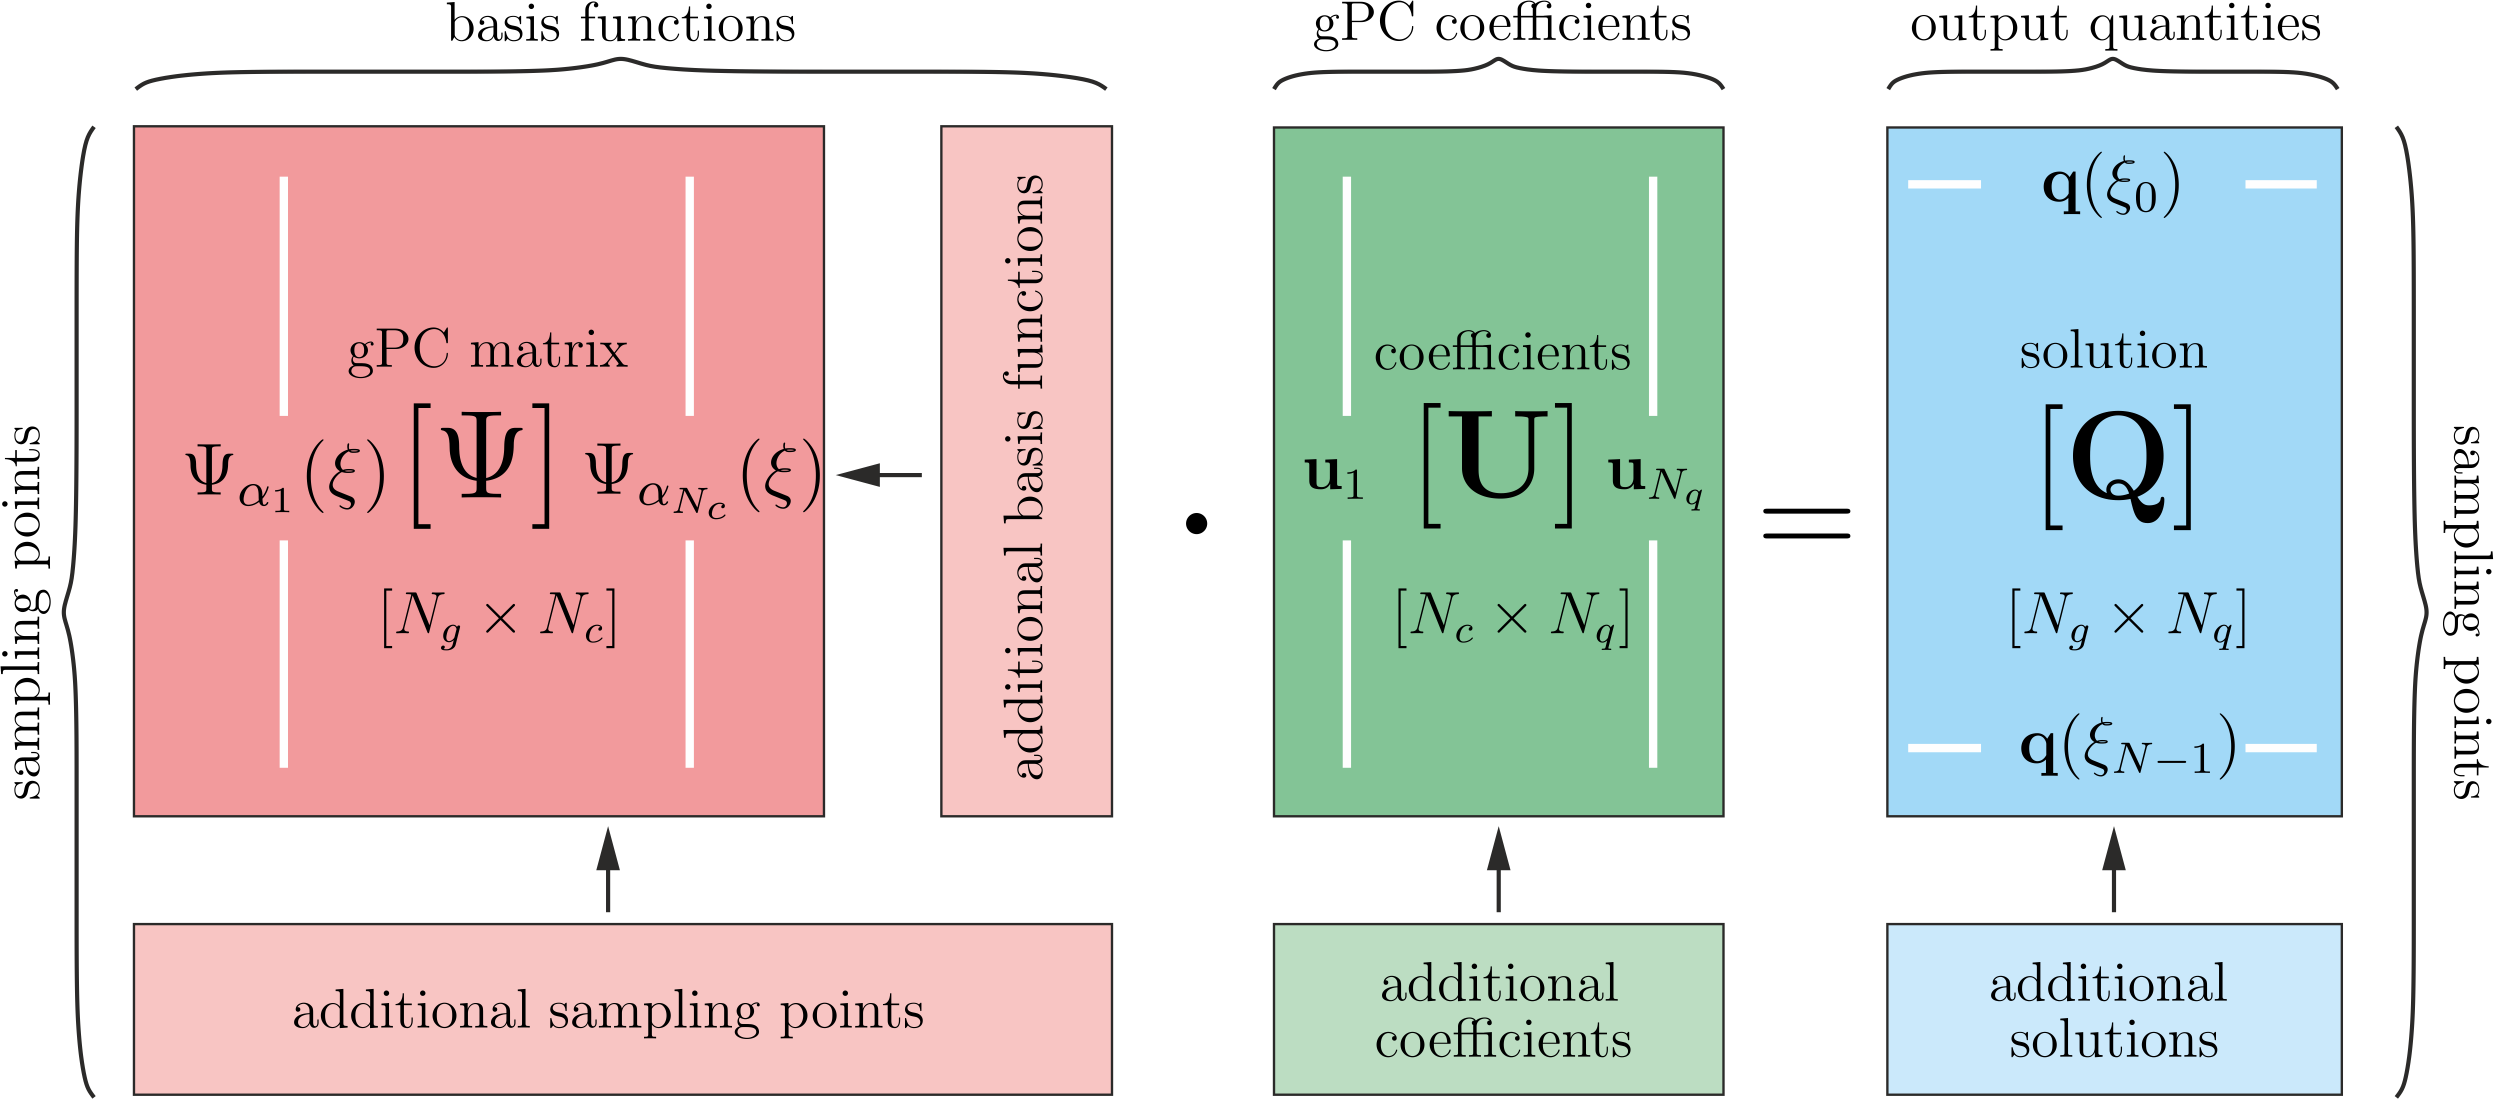

##### Moore-Penrose pseudo inverse:
Computes a "best fit" (least squares) solution to a system of linear equations that lacks a unique solution.

$$
[\mathbf{U}] = [\mathbf{\Psi}]^{+}[\mathbf{Y}]
$$

##### Least Angle Regression (LARS)
If the coefficients have a sufficiently rapid decay or if certain dimensions are dominant in an accurate reconstruction, we have a
*operative sparsity* of the approximation that leads to stable and convergent approximations. The index set $\mathcal{A}$ may have few *active* elements, allowing us to accurately reconstruct $[\mathbf{U}]$ using $N_g < N_c$ random samples (function evaluations), i.e., there exists a sparse representation for $[\mathbf{U}]$ as a linear combination of orthogonal polynomials in $\Theta$.



Here we employ compressive sampling, specifically the

Least-angle regression (LARS) is a regression algorithm for high-dimensional data, developed by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani. LARS is similar to forward stepwise regression.<br />

LARS-Lasso is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.<br />

The optimization objective for Lasso is:

$$
\frac{1}{2 N_g} \lVert y - Xw \rVert^2_2 + \alpha \lVert w \rVert_1
$$

**pygpc** makes use of of Scikit learn implementation [sklearn.linear_model.LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html). 

### Post-processing

After calculating the gPC-coefficients, the statistical moments of the QOIs $y(\mathbf{r},{\xi})$ can be calculated. 

##### Mean:
The expectations $\mu(\mathbf{r})$ are given by the first gPC coefficients:
$$
\mu(\mathbf{r}) = u_{\mathbf{\alpha}_0}(\mathbf{r})\\
$$

##### Variance:
The variance $\sigma(\mathbf{r})^2$ can be calculated by summing the remaining coefficients squared:
$$
\sigma(\mathbf{r})^2 = \sum\limits_{_{\mathbf{\alpha} \in \mathcal{A} \setminus \mathbf{a}_0} } u_{\mathbf{\alpha}}(\mathbf{r})^{2}
$$

##### Probability density function:
The pdfs of the QOIs can be determined by applying sampling strategies such as Monte Carlo, Latin Hypercube or Quasi Monte Carlo sampling with $N_{\text{MC}}$ realizations. Since the gPC surrogate constitutes of simple polynomials, a large number of samples such as ${N_{\text{MC}} \approx 10^5-10^6}$ can be used with vanishingly small computational effort compared to direct sampling. The drawn samples can be fitted to an appropriate distribution to parametrize it for further evaluations. Additional statistical tests can be applied to proof the null-hypothesis $H_0$ between the QOI and the assumed distribution.

#### Sensitivity coefficients
GPC enables comprehensive analyses to quantify the sensitivity of a system’s output with respect to its input parameters and their uncertainties, and thus to identify the parameters that contribute most to the uncertainty of the output variables. We outline two commonly used measures, namely Sobol indices and global derivative-based sensitivity coefficients.

#### Sobol indices
The Sobol indices $S_i^{(\nu)}$ decompose the total variance $\sigma^2$ of the quantity of interest into components that can be attributed to individual random variables $\xi_i$ or combinations thereof [Sobol (2001), Sudret (2008)]. For each $S_i^{(\nu)}$, we summed the squared coefficients $\mathbf{u}_{\mathbf{\alpha}}^2$, whose multi-indices $\mathbf{\alpha}$ belonged to the set $\mathcal{A}_i$ with non-zero values only for the $\xi_i$ of interest.

$$
S_i^{(\nu)} = \sum\limits_{_{\mathbf{\alpha} \in \mathcal{A}_i \setminus \mathbf{a}_0} } u_{\mathbf{\alpha}}(\mathbf{r})^{2}
$$

For example, if we want the Sobol coefficient $S_1^{(\nu)}$, we select $\mathcal{A}_1=\{\{1,0,…,0\},…,\{P,0,…,0\}\}$. The Sobol indices were normalized with respect to the total variance $\sigma^2$ and consequently add up to one. In some cases however, it is advantageous to omit this normalization, especially in cases where variances and mean values of different orders of magnitude are investigated at the same time, which is the case for field distributions at, e.g., points with high or almost negligible field intensity. Importantly, Sobol indices reflect the combined effect of the uncertainty of the input parameter and the dependence between the input and output parameters. For example, a low Sobol index could be due to a low uncertainty of the input parameter, a low sensitivity of the output towards the input parameter, or both. As such, Sobol indices are well suited to identify the most important input parameters given our actual (or assumed) knowledge about them.

#### Global derivative-based sensitivity coefficients
On the other hand, the global derivative-based sensitivity coefficients $S_i^{(\partial)}$ are measures of the average change of the quantity of interest with respect to the i-th random variable. They are determined by means of the gPC-coefficients and the corresponding partial derivatives of the basis functions [Xiu (2009)]:

$$
S_i^{(\partial)} = E\left[\frac{\partial \mathbf{q}(\xi)}{\partial \xi_i}\right] = \sum_(α∈A_i)▒u_α^   ∫_Θ▒〖(∂Ψ_α^  (ξ))/(∂ξ_i ) p(ξ)dξ
$$

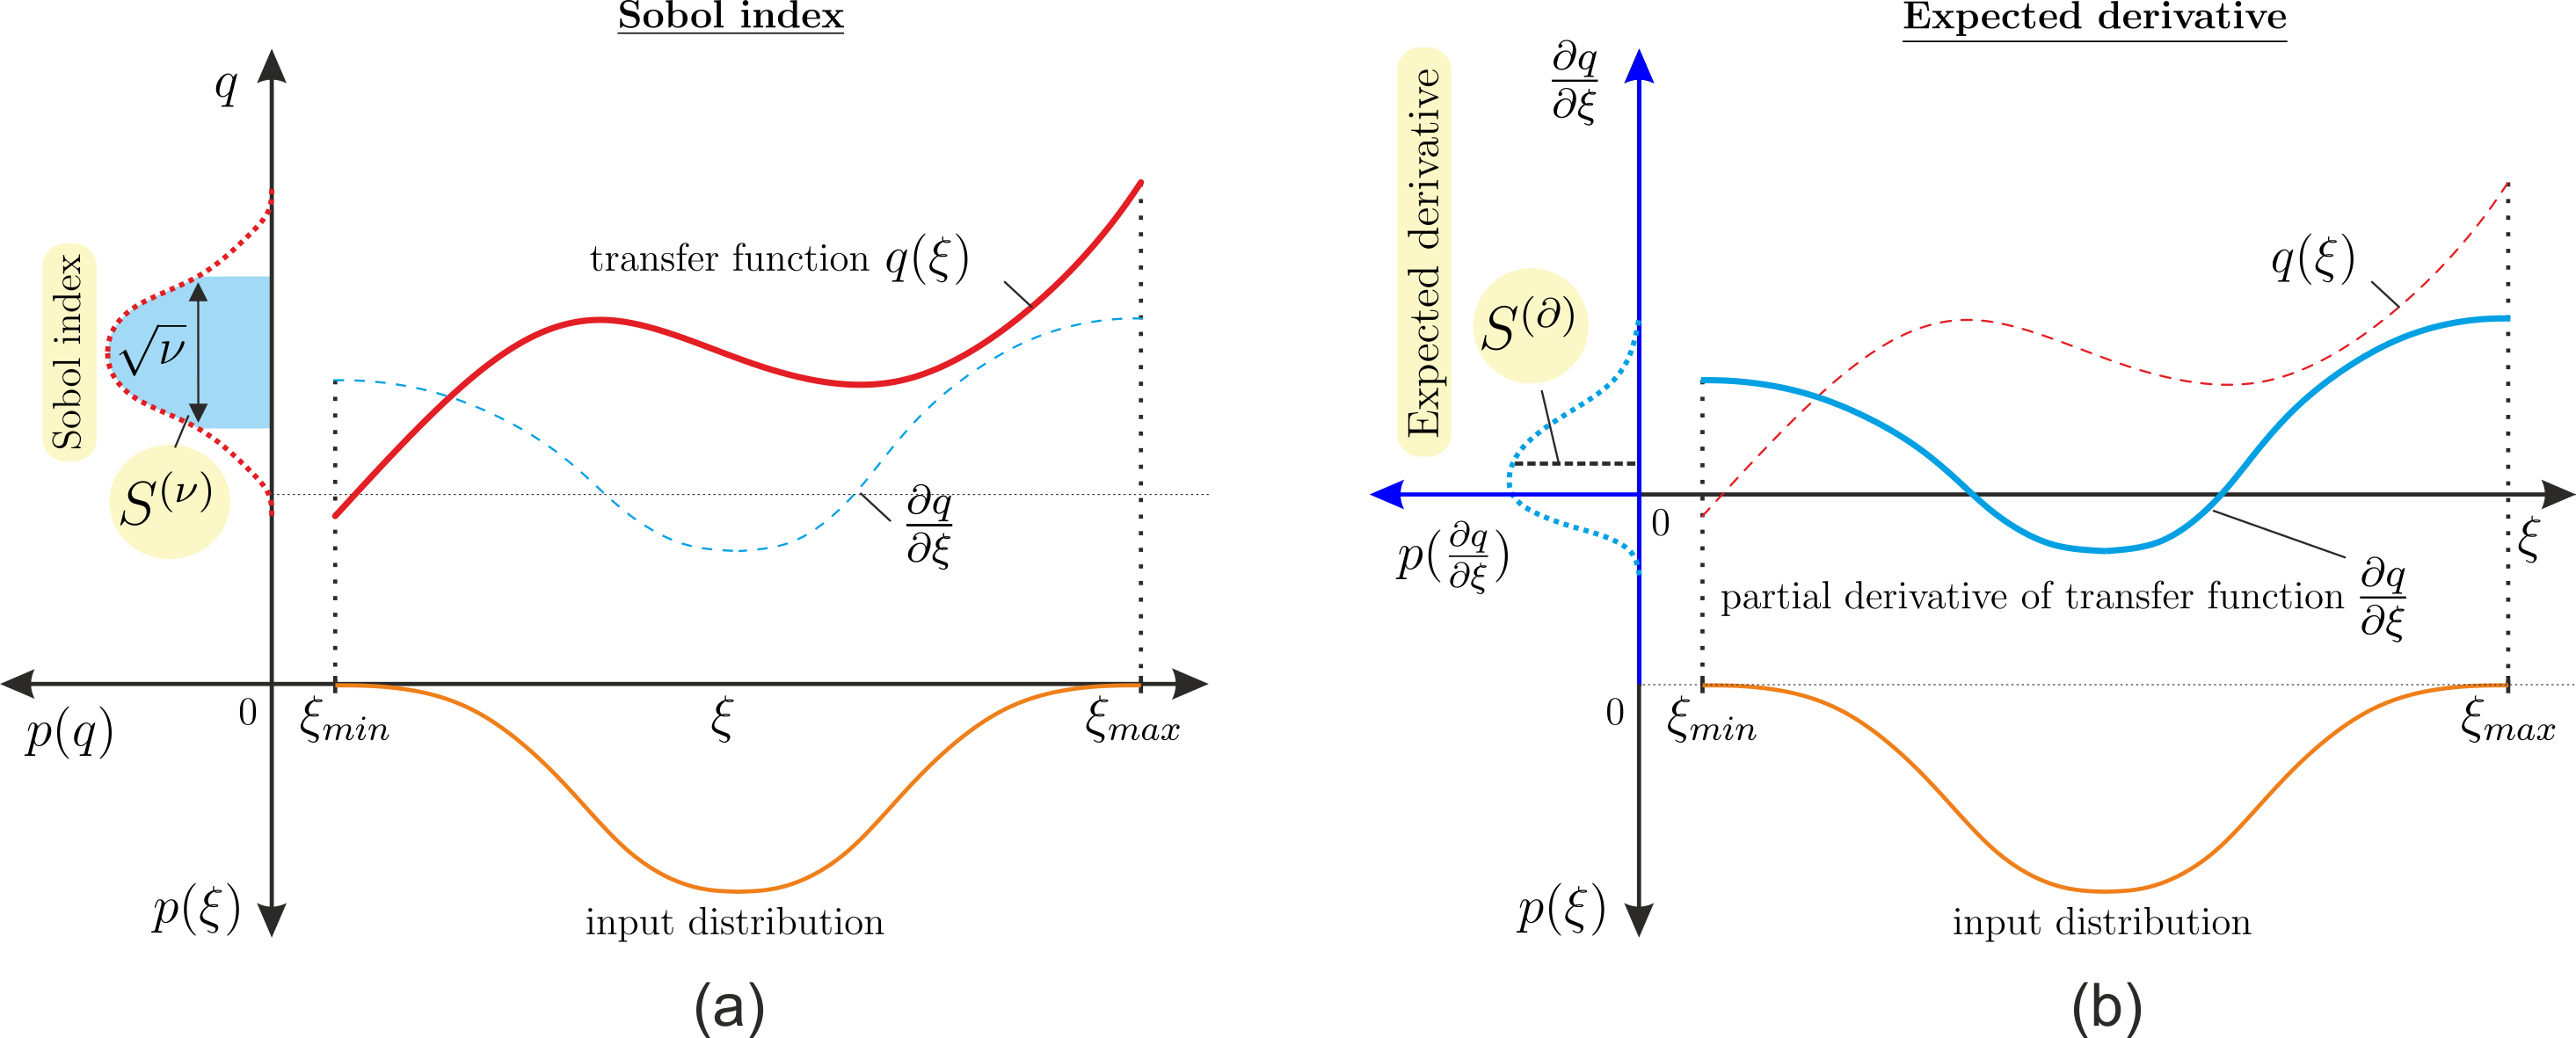

### Example: Static gPC

Performing 136 simulations!
It/Sub-it: 7/2 Performing simulation 001 from 136 [                                        ] 0.7%
Total parallel function evaluation: 0.0018346309661865234 sec
It/Sub-it: N/A/N/A Performing simulation 001 from 272 [                                        ] 0.4%
Gradient evaluation: 0.019669294357299805 sec
Determine gPC coefficients using 'Moore-Penrose' solver (gradient enhanced)...
It/Sub-it: N/A/N/A Performing simulation 00001 from 10000 [                                        ] 0.0%
-> relative nrmsd error = 0.04096524809632102
> Loading gpc object: pygpc_ishigami.pkl
> Loading gpc coeffs: /NOBACKUP2/tmp/pygpc_ishigami.hdf5
> Adding results to: /NOBACKUP2/tmp/pygpc_ishigami.hdf5
	 > Maximum NRMSD (gpc vs original): 0.041%
It/Sub-it: N/A/N/A Performing simulation 0001 from 2601 [                                        ] 0.0%
It/Sub-it: N/A/N/A Performing simulation 0002 from 2601 [                                        ] 0.1%
It/Sub-it: N/A/N/A Performi

It/Sub-it: N/A/N/A Performing simulation 0072 from 2601 [=                                       ] 2.8%
It/Sub-it: N/A/N/A Performing simulation 0073 from 2601 [=                                       ] 2.8%
It/Sub-it: N/A/N/A Performing simulation 0074 from 2601 [=                                       ] 2.8%
It/Sub-it: N/A/N/A Performing simulation 0075 from 2601 [=                                       ] 2.9%
It/Sub-it: N/A/N/A Performing simulation 0076 from 2601 [=                                       ] 2.9%
It/Sub-it: N/A/N/A Performing simulation 0077 from 2601 [=                                       ] 3.0%
It/Sub-it: N/A/N/A Performing simulation 0078 from 2601 [=                                       ] 3.0%
It/Sub-it: N/A/N/A Performing simulation 0079 from 2601 [=                                       ] 3.0%
It/Sub-it: N/A/N/A Performing simulation 0080 from 2601 [=                                       ] 3.1%
It/Sub-it: N/A/N/A Performing simulation 0081 from 2601 [=      

It/Sub-it: N/A/N/A Performing simulation 0150 from 2601 [==                                      ] 5.8%
It/Sub-it: N/A/N/A Performing simulation 0151 from 2601 [==                                      ] 5.8%
It/Sub-it: N/A/N/A Performing simulation 0152 from 2601 [==                                      ] 5.8%
It/Sub-it: N/A/N/A Performing simulation 0153 from 2601 [==                                      ] 5.9%
It/Sub-it: N/A/N/A Performing simulation 0154 from 2601 [==                                      ] 5.9%
It/Sub-it: N/A/N/A Performing simulation 0155 from 2601 [==                                      ] 6.0%
It/Sub-it: N/A/N/A Performing simulation 0156 from 2601 [==                                      ] 6.0%
It/Sub-it: N/A/N/A Performing simulation 0157 from 2601 [==                                      ] 6.0%
It/Sub-it: N/A/N/A Performing simulation 0158 from 2601 [==                                      ] 6.1%
It/Sub-it: N/A/N/A Performing simulation 0159 from 2601 [==     

It/Sub-it: N/A/N/A Performing simulation 0228 from 2601 [===                                     ] 8.8%
It/Sub-it: N/A/N/A Performing simulation 0229 from 2601 [===                                     ] 8.8%
It/Sub-it: N/A/N/A Performing simulation 0230 from 2601 [===                                     ] 8.8%
It/Sub-it: N/A/N/A Performing simulation 0231 from 2601 [===                                     ] 8.9%
It/Sub-it: N/A/N/A Performing simulation 0232 from 2601 [===                                     ] 8.9%
It/Sub-it: N/A/N/A Performing simulation 0233 from 2601 [===                                     ] 9.0%
It/Sub-it: N/A/N/A Performing simulation 0234 from 2601 [===                                     ] 9.0%
It/Sub-it: N/A/N/A Performing simulation 0235 from 2601 [===                                     ] 9.0%
It/Sub-it: N/A/N/A Performing simulation 0236 from 2601 [===                                     ] 9.1%
It/Sub-it: N/A/N/A Performing simulation 0237 from 2601 [===    

It/Sub-it: N/A/N/A Performing simulation 0306 from 2601 [====                                    ] 11.8%
It/Sub-it: N/A/N/A Performing simulation 0307 from 2601 [====                                    ] 11.8%
It/Sub-it: N/A/N/A Performing simulation 0308 from 2601 [====                                    ] 11.8%
It/Sub-it: N/A/N/A Performing simulation 0309 from 2601 [====                                    ] 11.9%
It/Sub-it: N/A/N/A Performing simulation 0310 from 2601 [====                                    ] 11.9%
It/Sub-it: N/A/N/A Performing simulation 0311 from 2601 [====                                    ] 12.0%
It/Sub-it: N/A/N/A Performing simulation 0312 from 2601 [====                                    ] 12.0%
It/Sub-it: N/A/N/A Performing simulation 0313 from 2601 [====                                    ] 12.0%
It/Sub-it: N/A/N/A Performing simulation 0314 from 2601 [====                                    ] 12.1%
It/Sub-it: N/A/N/A Performing simulation 0315 from 2601

It/Sub-it: N/A/N/A Performing simulation 0384 from 2601 [=====                                   ] 14.8%
It/Sub-it: N/A/N/A Performing simulation 0385 from 2601 [=====                                   ] 14.8%
It/Sub-it: N/A/N/A Performing simulation 0386 from 2601 [=====                                   ] 14.8%
It/Sub-it: N/A/N/A Performing simulation 0387 from 2601 [=====                                   ] 14.9%
It/Sub-it: N/A/N/A Performing simulation 0388 from 2601 [=====                                   ] 14.9%
It/Sub-it: N/A/N/A Performing simulation 0389 from 2601 [=====                                   ] 15.0%
It/Sub-it: N/A/N/A Performing simulation 0390 from 2601 [=====                                   ] 15.0%
It/Sub-it: N/A/N/A Performing simulation 0391 from 2601 [======                                  ] 15.0%
It/Sub-it: N/A/N/A Performing simulation 0392 from 2601 [======                                  ] 15.1%
It/Sub-it: N/A/N/A Performing simulation 0393 from 2601

It/Sub-it: N/A/N/A Performing simulation 0462 from 2601 [=======                                 ] 17.8%
It/Sub-it: N/A/N/A Performing simulation 0463 from 2601 [=======                                 ] 17.8%
It/Sub-it: N/A/N/A Performing simulation 0464 from 2601 [=======                                 ] 17.8%
It/Sub-it: N/A/N/A Performing simulation 0465 from 2601 [=======                                 ] 17.9%
It/Sub-it: N/A/N/A Performing simulation 0466 from 2601 [=======                                 ] 17.9%
It/Sub-it: N/A/N/A Performing simulation 0467 from 2601 [=======                                 ] 18.0%
It/Sub-it: N/A/N/A Performing simulation 0468 from 2601 [=======                                 ] 18.0%
It/Sub-it: N/A/N/A Performing simulation 0469 from 2601 [=======                                 ] 18.0%
It/Sub-it: N/A/N/A Performing simulation 0470 from 2601 [=======                                 ] 18.1%
It/Sub-it: N/A/N/A Performing simulation 0471 from 2601

It/Sub-it: N/A/N/A Performing simulation 0540 from 2601 [========                                ] 20.8%
It/Sub-it: N/A/N/A Performing simulation 0541 from 2601 [========                                ] 20.8%
It/Sub-it: N/A/N/A Performing simulation 0542 from 2601 [========                                ] 20.8%
It/Sub-it: N/A/N/A Performing simulation 0543 from 2601 [========                                ] 20.9%
It/Sub-it: N/A/N/A Performing simulation 0544 from 2601 [========                                ] 20.9%
It/Sub-it: N/A/N/A Performing simulation 0545 from 2601 [========                                ] 21.0%
It/Sub-it: N/A/N/A Performing simulation 0546 from 2601 [========                                ] 21.0%
It/Sub-it: N/A/N/A Performing simulation 0547 from 2601 [========                                ] 21.0%
It/Sub-it: N/A/N/A Performing simulation 0548 from 2601 [========                                ] 21.1%
It/Sub-it: N/A/N/A Performing simulation 0549 from 2601

It/Sub-it: N/A/N/A Performing simulation 0618 from 2601 [=========                               ] 23.8%
It/Sub-it: N/A/N/A Performing simulation 0619 from 2601 [=========                               ] 23.8%
It/Sub-it: N/A/N/A Performing simulation 0620 from 2601 [=========                               ] 23.8%
It/Sub-it: N/A/N/A Performing simulation 0621 from 2601 [=========                               ] 23.9%
It/Sub-it: N/A/N/A Performing simulation 0622 from 2601 [=========                               ] 23.9%
It/Sub-it: N/A/N/A Performing simulation 0623 from 2601 [=========                               ] 24.0%
It/Sub-it: N/A/N/A Performing simulation 0624 from 2601 [=========                               ] 24.0%
It/Sub-it: N/A/N/A Performing simulation 0625 from 2601 [=========                               ] 24.0%
It/Sub-it: N/A/N/A Performing simulation 0626 from 2601 [=========                               ] 24.1%
It/Sub-it: N/A/N/A Performing simulation 0627 from 2601

It/Sub-it: N/A/N/A Performing simulation 0696 from 2601 [==========                              ] 26.8%
It/Sub-it: N/A/N/A Performing simulation 0697 from 2601 [==========                              ] 26.8%
It/Sub-it: N/A/N/A Performing simulation 0698 from 2601 [==========                              ] 26.8%
It/Sub-it: N/A/N/A Performing simulation 0699 from 2601 [==========                              ] 26.9%
It/Sub-it: N/A/N/A Performing simulation 0700 from 2601 [==========                              ] 26.9%
It/Sub-it: N/A/N/A Performing simulation 0701 from 2601 [==========                              ] 27.0%
It/Sub-it: N/A/N/A Performing simulation 0702 from 2601 [==========                              ] 27.0%
It/Sub-it: N/A/N/A Performing simulation 0703 from 2601 [==========                              ] 27.0%
It/Sub-it: N/A/N/A Performing simulation 0704 from 2601 [==========                              ] 27.1%
It/Sub-it: N/A/N/A Performing simulation 0705 from 2601

It/Sub-it: N/A/N/A Performing simulation 0774 from 2601 [===========                             ] 29.8%
It/Sub-it: N/A/N/A Performing simulation 0775 from 2601 [===========                             ] 29.8%
It/Sub-it: N/A/N/A Performing simulation 0776 from 2601 [===========                             ] 29.8%
It/Sub-it: N/A/N/A Performing simulation 0777 from 2601 [===========                             ] 29.9%
It/Sub-it: N/A/N/A Performing simulation 0778 from 2601 [===========                             ] 29.9%
It/Sub-it: N/A/N/A Performing simulation 0779 from 2601 [===========                             ] 30.0%
It/Sub-it: N/A/N/A Performing simulation 0780 from 2601 [===========                             ] 30.0%
It/Sub-it: N/A/N/A Performing simulation 0781 from 2601 [============                            ] 30.0%
It/Sub-it: N/A/N/A Performing simulation 0782 from 2601 [============                            ] 30.1%
It/Sub-it: N/A/N/A Performing simulation 0783 from 2601

It/Sub-it: N/A/N/A Performing simulation 0852 from 2601 [=============                           ] 32.8%
It/Sub-it: N/A/N/A Performing simulation 0853 from 2601 [=============                           ] 32.8%
It/Sub-it: N/A/N/A Performing simulation 0854 from 2601 [=============                           ] 32.8%
It/Sub-it: N/A/N/A Performing simulation 0855 from 2601 [=============                           ] 32.9%
It/Sub-it: N/A/N/A Performing simulation 0856 from 2601 [=============                           ] 32.9%
It/Sub-it: N/A/N/A Performing simulation 0857 from 2601 [=============                           ] 32.9%
It/Sub-it: N/A/N/A Performing simulation 0858 from 2601 [=============                           ] 33.0%
It/Sub-it: N/A/N/A Performing simulation 0859 from 2601 [=============                           ] 33.0%
It/Sub-it: N/A/N/A Performing simulation 0860 from 2601 [=============                           ] 33.1%
It/Sub-it: N/A/N/A Performing simulation 0861 from 2601

It/Sub-it: N/A/N/A Performing simulation 0930 from 2601 [==============                          ] 35.8%
It/Sub-it: N/A/N/A Performing simulation 0931 from 2601 [==============                          ] 35.8%
It/Sub-it: N/A/N/A Performing simulation 0932 from 2601 [==============                          ] 35.8%
It/Sub-it: N/A/N/A Performing simulation 0933 from 2601 [==============                          ] 35.9%
It/Sub-it: N/A/N/A Performing simulation 0934 from 2601 [==============                          ] 35.9%
It/Sub-it: N/A/N/A Performing simulation 0935 from 2601 [==============                          ] 35.9%
It/Sub-it: N/A/N/A Performing simulation 0936 from 2601 [==============                          ] 36.0%
It/Sub-it: N/A/N/A Performing simulation 0937 from 2601 [==============                          ] 36.0%
It/Sub-it: N/A/N/A Performing simulation 0938 from 2601 [==============                          ] 36.1%
It/Sub-it: N/A/N/A Performing simulation 0939 from 2601

It/Sub-it: N/A/N/A Performing simulation 1008 from 2601 [===============                         ] 38.8%
It/Sub-it: N/A/N/A Performing simulation 1009 from 2601 [===============                         ] 38.8%
It/Sub-it: N/A/N/A Performing simulation 1010 from 2601 [===============                         ] 38.8%
It/Sub-it: N/A/N/A Performing simulation 1011 from 2601 [===============                         ] 38.9%
It/Sub-it: N/A/N/A Performing simulation 1012 from 2601 [===============                         ] 38.9%
It/Sub-it: N/A/N/A Performing simulation 1013 from 2601 [===============                         ] 38.9%
It/Sub-it: N/A/N/A Performing simulation 1014 from 2601 [===============                         ] 39.0%
It/Sub-it: N/A/N/A Performing simulation 1015 from 2601 [===============                         ] 39.0%
It/Sub-it: N/A/N/A Performing simulation 1016 from 2601 [===============                         ] 39.1%
It/Sub-it: N/A/N/A Performing simulation 1017 from 2601

It/Sub-it: N/A/N/A Performing simulation 1086 from 2601 [================                        ] 41.8%
It/Sub-it: N/A/N/A Performing simulation 1087 from 2601 [================                        ] 41.8%
It/Sub-it: N/A/N/A Performing simulation 1088 from 2601 [================                        ] 41.8%
It/Sub-it: N/A/N/A Performing simulation 1089 from 2601 [================                        ] 41.9%
It/Sub-it: N/A/N/A Performing simulation 1090 from 2601 [================                        ] 41.9%
It/Sub-it: N/A/N/A Performing simulation 1091 from 2601 [================                        ] 41.9%
It/Sub-it: N/A/N/A Performing simulation 1092 from 2601 [================                        ] 42.0%
It/Sub-it: N/A/N/A Performing simulation 1093 from 2601 [================                        ] 42.0%
It/Sub-it: N/A/N/A Performing simulation 1094 from 2601 [================                        ] 42.1%
It/Sub-it: N/A/N/A Performing simulation 1095 from 2601

It/Sub-it: N/A/N/A Performing simulation 1164 from 2601 [=================                       ] 44.8%
It/Sub-it: N/A/N/A Performing simulation 1165 from 2601 [=================                       ] 44.8%
It/Sub-it: N/A/N/A Performing simulation 1166 from 2601 [=================                       ] 44.8%
It/Sub-it: N/A/N/A Performing simulation 1167 from 2601 [=================                       ] 44.9%
It/Sub-it: N/A/N/A Performing simulation 1168 from 2601 [=================                       ] 44.9%
It/Sub-it: N/A/N/A Performing simulation 1169 from 2601 [=================                       ] 44.9%
It/Sub-it: N/A/N/A Performing simulation 1170 from 2601 [=================                       ] 45.0%
It/Sub-it: N/A/N/A Performing simulation 1171 from 2601 [==================                      ] 45.0%
It/Sub-it: N/A/N/A Performing simulation 1172 from 2601 [==================                      ] 45.1%
It/Sub-it: N/A/N/A Performing simulation 1173 from 2601

It/Sub-it: N/A/N/A Performing simulation 1242 from 2601 [===================                     ] 47.8%
It/Sub-it: N/A/N/A Performing simulation 1243 from 2601 [===================                     ] 47.8%
It/Sub-it: N/A/N/A Performing simulation 1244 from 2601 [===================                     ] 47.8%
It/Sub-it: N/A/N/A Performing simulation 1245 from 2601 [===================                     ] 47.9%
It/Sub-it: N/A/N/A Performing simulation 1246 from 2601 [===================                     ] 47.9%
It/Sub-it: N/A/N/A Performing simulation 1247 from 2601 [===================                     ] 47.9%
It/Sub-it: N/A/N/A Performing simulation 1248 from 2601 [===================                     ] 48.0%
It/Sub-it: N/A/N/A Performing simulation 1249 from 2601 [===================                     ] 48.0%
It/Sub-it: N/A/N/A Performing simulation 1250 from 2601 [===================                     ] 48.1%
It/Sub-it: N/A/N/A Performing simulation 1251 from 2601

It/Sub-it: N/A/N/A Performing simulation 1320 from 2601 [====================                    ] 50.7%
It/Sub-it: N/A/N/A Performing simulation 1321 from 2601 [====================                    ] 50.8%
It/Sub-it: N/A/N/A Performing simulation 1322 from 2601 [====================                    ] 50.8%
It/Sub-it: N/A/N/A Performing simulation 1323 from 2601 [====================                    ] 50.9%
It/Sub-it: N/A/N/A Performing simulation 1324 from 2601 [====================                    ] 50.9%
It/Sub-it: N/A/N/A Performing simulation 1325 from 2601 [====================                    ] 50.9%
It/Sub-it: N/A/N/A Performing simulation 1326 from 2601 [====================                    ] 51.0%
It/Sub-it: N/A/N/A Performing simulation 1327 from 2601 [====================                    ] 51.0%
It/Sub-it: N/A/N/A Performing simulation 1328 from 2601 [====================                    ] 51.1%
It/Sub-it: N/A/N/A Performing simulation 1329 from 2601

It/Sub-it: N/A/N/A Performing simulation 1398 from 2601 [=====================                   ] 53.7%
It/Sub-it: N/A/N/A Performing simulation 1399 from 2601 [=====================                   ] 53.8%
It/Sub-it: N/A/N/A Performing simulation 1400 from 2601 [=====================                   ] 53.8%
It/Sub-it: N/A/N/A Performing simulation 1401 from 2601 [=====================                   ] 53.9%
It/Sub-it: N/A/N/A Performing simulation 1402 from 2601 [=====================                   ] 53.9%
It/Sub-it: N/A/N/A Performing simulation 1403 from 2601 [=====================                   ] 53.9%
It/Sub-it: N/A/N/A Performing simulation 1404 from 2601 [=====================                   ] 54.0%
It/Sub-it: N/A/N/A Performing simulation 1405 from 2601 [=====================                   ] 54.0%
It/Sub-it: N/A/N/A Performing simulation 1406 from 2601 [=====================                   ] 54.1%
It/Sub-it: N/A/N/A Performing simulation 1407 from 2601

It/Sub-it: N/A/N/A Performing simulation 1476 from 2601 [======================                  ] 56.7%
It/Sub-it: N/A/N/A Performing simulation 1477 from 2601 [======================                  ] 56.8%
It/Sub-it: N/A/N/A Performing simulation 1478 from 2601 [======================                  ] 56.8%
It/Sub-it: N/A/N/A Performing simulation 1479 from 2601 [======================                  ] 56.9%
It/Sub-it: N/A/N/A Performing simulation 1480 from 2601 [======================                  ] 56.9%
It/Sub-it: N/A/N/A Performing simulation 1481 from 2601 [======================                  ] 56.9%
It/Sub-it: N/A/N/A Performing simulation 1482 from 2601 [======================                  ] 57.0%
It/Sub-it: N/A/N/A Performing simulation 1483 from 2601 [======================                  ] 57.0%
It/Sub-it: N/A/N/A Performing simulation 1484 from 2601 [======================                  ] 57.1%
It/Sub-it: N/A/N/A Performing simulation 1485 from 2601

It/Sub-it: N/A/N/A Performing simulation 1554 from 2601 [=======================                 ] 59.7%
It/Sub-it: N/A/N/A Performing simulation 1555 from 2601 [=======================                 ] 59.8%
It/Sub-it: N/A/N/A Performing simulation 1556 from 2601 [=======================                 ] 59.8%
It/Sub-it: N/A/N/A Performing simulation 1557 from 2601 [=======================                 ] 59.9%
It/Sub-it: N/A/N/A Performing simulation 1558 from 2601 [=======================                 ] 59.9%
It/Sub-it: N/A/N/A Performing simulation 1559 from 2601 [=======================                 ] 59.9%
It/Sub-it: N/A/N/A Performing simulation 1560 from 2601 [=======================                 ] 60.0%
It/Sub-it: N/A/N/A Performing simulation 1561 from 2601 [========================                ] 60.0%
It/Sub-it: N/A/N/A Performing simulation 1562 from 2601 [========================                ] 60.1%
It/Sub-it: N/A/N/A Performing simulation 1563 from 2601

It/Sub-it: N/A/N/A Performing simulation 1632 from 2601 [=========================               ] 62.7%
It/Sub-it: N/A/N/A Performing simulation 1633 from 2601 [=========================               ] 62.8%
It/Sub-it: N/A/N/A Performing simulation 1634 from 2601 [=========================               ] 62.8%
It/Sub-it: N/A/N/A Performing simulation 1635 from 2601 [=========================               ] 62.9%
It/Sub-it: N/A/N/A Performing simulation 1636 from 2601 [=========================               ] 62.9%
It/Sub-it: N/A/N/A Performing simulation 1637 from 2601 [=========================               ] 62.9%
It/Sub-it: N/A/N/A Performing simulation 1638 from 2601 [=========================               ] 63.0%
It/Sub-it: N/A/N/A Performing simulation 1639 from 2601 [=========================               ] 63.0%
It/Sub-it: N/A/N/A Performing simulation 1640 from 2601 [=========================               ] 63.1%
It/Sub-it: N/A/N/A Performing simulation 1641 from 2601

It/Sub-it: N/A/N/A Performing simulation 1710 from 2601 [==========================              ] 65.7%
It/Sub-it: N/A/N/A Performing simulation 1711 from 2601 [==========================              ] 65.8%
It/Sub-it: N/A/N/A Performing simulation 1712 from 2601 [==========================              ] 65.8%
It/Sub-it: N/A/N/A Performing simulation 1713 from 2601 [==========================              ] 65.9%
It/Sub-it: N/A/N/A Performing simulation 1714 from 2601 [==========================              ] 65.9%
It/Sub-it: N/A/N/A Performing simulation 1715 from 2601 [==========================              ] 65.9%
It/Sub-it: N/A/N/A Performing simulation 1716 from 2601 [==========================              ] 66.0%
It/Sub-it: N/A/N/A Performing simulation 1717 from 2601 [==========================              ] 66.0%
It/Sub-it: N/A/N/A Performing simulation 1718 from 2601 [==========================              ] 66.1%
It/Sub-it: N/A/N/A Performing simulation 1719 from 2601

It/Sub-it: N/A/N/A Performing simulation 1788 from 2601 [===========================             ] 68.7%
It/Sub-it: N/A/N/A Performing simulation 1789 from 2601 [===========================             ] 68.8%
It/Sub-it: N/A/N/A Performing simulation 1790 from 2601 [===========================             ] 68.8%
It/Sub-it: N/A/N/A Performing simulation 1791 from 2601 [===========================             ] 68.9%
It/Sub-it: N/A/N/A Performing simulation 1792 from 2601 [===========================             ] 68.9%
It/Sub-it: N/A/N/A Performing simulation 1793 from 2601 [===========================             ] 68.9%
It/Sub-it: N/A/N/A Performing simulation 1794 from 2601 [===========================             ] 69.0%
It/Sub-it: N/A/N/A Performing simulation 1795 from 2601 [===========================             ] 69.0%
It/Sub-it: N/A/N/A Performing simulation 1796 from 2601 [===========================             ] 69.1%
It/Sub-it: N/A/N/A Performing simulation 1797 from 2601

It/Sub-it: N/A/N/A Performing simulation 1866 from 2601 [============================            ] 71.7%
It/Sub-it: N/A/N/A Performing simulation 1867 from 2601 [============================            ] 71.8%
It/Sub-it: N/A/N/A Performing simulation 1868 from 2601 [============================            ] 71.8%
It/Sub-it: N/A/N/A Performing simulation 1869 from 2601 [============================            ] 71.9%
It/Sub-it: N/A/N/A Performing simulation 1870 from 2601 [============================            ] 71.9%
It/Sub-it: N/A/N/A Performing simulation 1871 from 2601 [============================            ] 71.9%
It/Sub-it: N/A/N/A Performing simulation 1872 from 2601 [============================            ] 72.0%
It/Sub-it: N/A/N/A Performing simulation 1873 from 2601 [============================            ] 72.0%
It/Sub-it: N/A/N/A Performing simulation 1874 from 2601 [============================            ] 72.0%
It/Sub-it: N/A/N/A Performing simulation 1875 from 2601

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



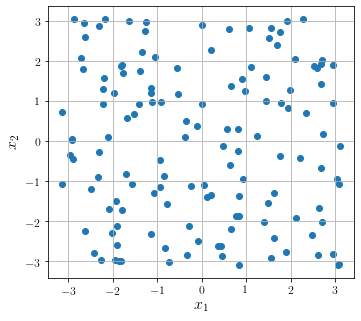

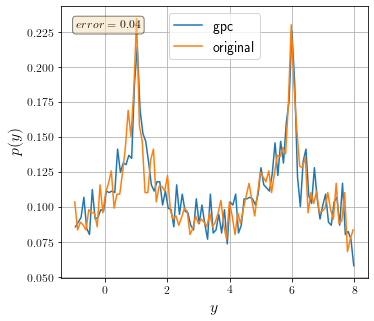

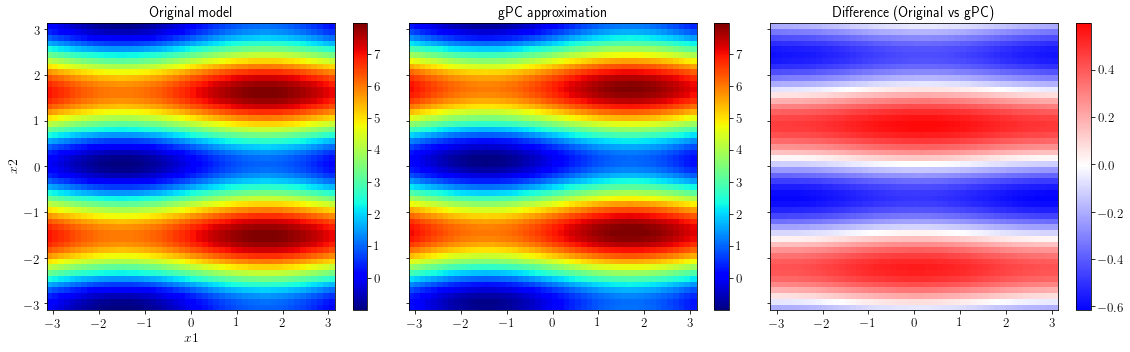

In [2]:
folder = "/NOBACKUP2/tmp"
test_name = 'pygpc_ishigami'

# define model
model = pygpc.testfunctions.Ishigami

# define parameters
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x2"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x3"] = 0.
parameters["a"] = 7.
parameters["b"] = 0.1

# define problem
problem = pygpc.Problem(model, parameters)

# gPC options
options = dict()
options["method"] = "reg"
options["solver"] = "Moore-Penrose"
options["settings"] = None
options["order"] = [15, 15]
options["order_max"] = 7
options["interaction_order"] = 2
options["matrix_ratio"] = 2
options["error_type"] = "nrmsd"
options["n_cpu"] = 0
options["fn_results"] = os.path.join(folder, test_name)
options["gradient_enhanced"] = True
options["GPU"] = False
        
# generate grid
n_coeffs = pygpc.get_num_coeffs_sparse(order_dim_max=options["order"],
                                       order_glob_max=options["order_max"],
                                       order_inter_max=options["interaction_order"],
                                       dim=problem.dim)

grid = pygpc.RandomGrid(parameters_random=problem.parameters_random,
                        options={"n_grid": options["matrix_ratio"] * n_coeffs, "seed": 1})

pygpc.plot_2d_grid(coords=grid.coords, fn_plot=os.path.join(folder, test_name + '_grid'))

# define algorithm
algorithm = pygpc.Static(problem=problem, options=options, grid=grid)

# run gPC algorithm
gpc, coeffs, results = algorithm.run()

# Post-process gPC
pygpc.get_sensitivities_hdf5(fn_gpc=options["fn_results"],
                                     output_idx=None,
                                     calc_sobol=True,
                                     calc_global_sens=True,
                                     calc_pdf=True,
                                     algorithm="standard")

# Validate gPC vs original model function (Monte Carlo)
nrmsd = pygpc.validate_gpc_mc(gpc=gpc,
                              coeffs=coeffs,
                              n_samples=int(1e4),
                              output_idx=0,
                              fn_out=os.path.join(folder, test_name + '_validation_mc'))

print("\t > Maximum NRMSD (gpc vs original): {:.2}%".format(np.max(nrmsd)))

# Validate gPC vs original model function (2D-slice)
pygpc.validate_gpc_plot(gpc=gpc,
                        coeffs=coeffs,
                        random_vars=["x1", "x2"],
                        n_grid=[51, 51],
                        output_idx=[0],
                        fn_out=os.path.join(folder, test_name + '_validation_2d'))

In [ ]:
<cite data-cite="LeMaitre.2010">(Le Maitre, 2010)</cite>
%%bash
ipython nbconvert --to latex --template citation_style_template.tplx Tutorial_pygpc_pyrates.ipynb
pdflatex Tutorial_pygpc_pyrates.tex
bibtex Tutorial_pygpc_pyrates
pdflatex Tutorial_pygpc_pyrates.tex